# Intro

This notebook provides minimal functionality for applying DMD to noisy climate data. 

The following capabilities are implemented:

* use mask to remove land pixels from training
* window average (window before current time)
* densely sample weekly means around local mins of total ice
* model monthly across years


In [75]:
%load_ext autoreload
%autoreload 2
import dill

import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD, BOPDMD, FbDMD, MrDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D
from pydmd.preprocessing import hankel_preprocessing

from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.ndimage import gaussian_filter

from tqdm.autonotebook import tqdm, trange

from scipy.signal import fftconvolve

import sys

sys.path.insert(0, '../src/WeatherDMD/')

from WeatherDMD.plot_jupyter import contour_compare, contour_data
from WeatherDMD.data_wrangle import get_days_before, get_test_set, window_mean
from WeatherDMD.dmd_routines import reshape_data2dmd, train_dmd, reshape_Psi2data, eval_dmd

import xarray

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DATA

In [76]:
dSet = xarray.open_zarr("../data/2020-01-01_2020-02-27_era5_slice_resampled.zarr")  

In [78]:
dSet

<xarray.Dataset> Size: 724MB
Dimensions:              (time: 232, level: 1, latitude: 361, longitude: 720)
Coordinates:
  * latitude             (latitude) float32 1kB 90.0 89.5 89.0 ... -89.5 -90.0
  * level                (level) int64 8B 1000
  * longitude            (longitude) float32 3kB 0.0 0.5 1.0 ... 359.0 359.5
  * time                 (time) datetime64[ns] 2kB 2020-01-01 ... 2020-02-27T...
Data variables:
    geopotential         (time, level, latitude, longitude) float32 241MB ...
    temperature          (time, level, latitude, longitude) float32 241MB ...
    u_component_of_wind  (time, level, latitude, longitude) float32 241MB ...

In [124]:
# calculate the unique delta time in hours
delta_time = np.unique(np.diff(dSet.time))
delta_time = delta_time/np.timedelta64(1, 'h')
delta_time = delta_time[0]
print(f"The unique delta time is {delta_time} hours")

The unique delta time is 6.0 hours


In [82]:
variable = dSet.variables['temperature'].isel(level=0)
variable

<xarray.Variable (time: 232, latitude: 361, longitude: 720)> Size: 241MB
[60301440 values with dtype=float32]
Attributes:
    long_name:      Temperature
    short_name:     t
    standard_name:  air_temperature
    units:          K

In [83]:
variable.shape

(232, 361, 720)

In [84]:
# currently the number of points in lat and lon need to be the same for this pipeline to work
data = variable[:, :360, :360][:, ::3, ::3]  # 3x3 downsample

In [85]:
data.shape

(232, 120, 120)

In [89]:
DATA = np.array(data)[None, ...]

In [90]:
DATA.shape

(1, 232, 120, 120)

In [91]:
contour_data(data)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=231), IntSlider(value=60, description='f_…

In [92]:
data.shape

(232, 120, 120)

In [95]:
x = np.linspace(0, 1, data.shape[2])
y = np.linspace(0, 1, data.shape[1])

In [96]:
# compute the integral of the field along the x and y axis (across space)
Integral_pred = np.trapz(np.trapz(data, x, axis = 2), y, axis = 1)

Text(0, 0.5, 'Integral of the field')

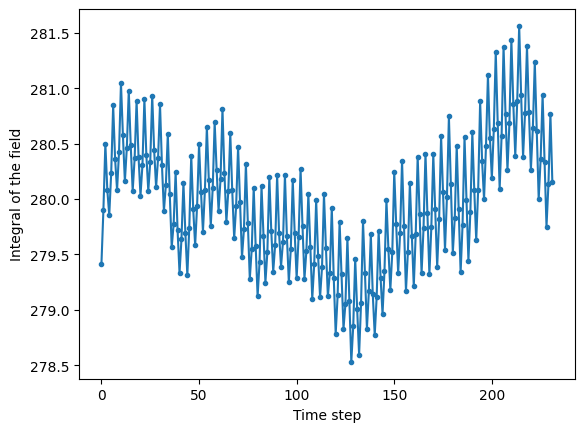

In [99]:
fig, ax = plt.subplots()
plt.plot(Integral_pred, '.-')
plt.xlabel('Time step')
plt.ylabel('Integral of the field')

## Train optimised DMD

DMD does not really require batching the data in the deep-AI sense. We simply need to select a training interval and fit DMD. After fitting, DMD model with fitted parameters can be used for prediction on any time interval. 

1. Identify a starting point in time by `year`, `day` 
2. Identify, how many days to train on: `T_train`
3. Select subset of `DATA`, based on the above. Perform window-averaging to de-noise it. 
4. Fit DMD. 
5. Compute DMD predictions from `year`, `day` forward. 

In [100]:
DATA[0].shape

(232, 120, 120)

In [101]:
len(DATA)

1

In [102]:
#
year = 0
day = 150

window = 10
T_train = 100

# compute windowed mean. Returns T_train snapshots before current time point (not inclusive)
X0_ = get_days_before(DATA, year, day, T_train+window-1)
X0 = window_mean(X0_, window = window, t = None)


X0_.shape, X0.shape

((109, 120, 120), (100, 120, 120))

In [103]:
contour_compare(X0_[window-1:], X0)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=99), IntSlider(value=60, description='f_i…

In [104]:
X0.shape

(100, 120, 120)

In [106]:
rank = 3
t = np.arange(-T_train, 0)

# time delay and dmd snapshots
X_delayed, t_delayed, data_shape = reshape_data2dmd(X0, t, time_delay = 2, 
                                                     mask = None,
                                                    isKeepFirstTimes = True)
# train dmd
Lambda, Psi_, bn = train_dmd(X_delayed, t_delayed, rank = rank)

Psi = reshape_Psi2data(Psi_, data_shape, mask = None)

In [107]:
Psi.shape

(3, 120, 120)

In [108]:
t = np.arange(-T_train, T_train)
true_after = get_test_set(DATA, year, day, window, T_train + window -1)
X_true = np.concatenate((X0, true_after), axis = 0)

X_pred = eval_dmd(Lambda, Psi, bn, t)

In [109]:
true_after.shape

(82, 120, 120)

/var/folders/3p/bn7y7hcd6s7_28j4tq3cv2hr0000gs/T/ipykernel_31724/1071256060.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 'upper right')


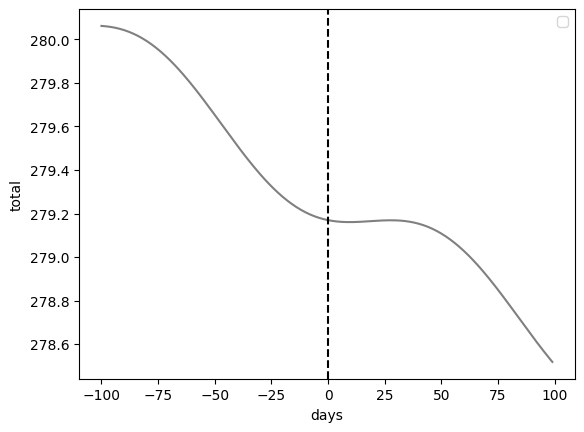

In [112]:
# COMPUTE METRIC OF PREDICTION
Integral_pred = np.trapz(np.trapz(X_pred, x, axis = 2), y, axis = 1)
Integral_true = np.trapz(np.trapz(X_true, x, axis = 2), y, axis = 1)

# plt.plot(t, Integral_pred1.T, color = 'k');
plt.plot(t, Integral_pred.T, color = 'grey');
# plt.plot(t, Integral_true, label = 'true total', color = 'r')
plt.axvline(0, linestyle = '--', color = 'k')

plt.ylabel('total')
plt.xlabel('days')

plt.legend(loc = 'upper right')

In [113]:
contour_compare(X_true, X_pred[:182])

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=181), IntSlider(value=60, description='f_…

In [114]:
rmse = np.linalg.norm(X_true - X_pred[:182], axis = (1, 2)) / (X_true.shape[1] * X_true.shape[2])

In [115]:
rmse.shape

(182,)

Text(0, 0.5, 'RMSE (%)')

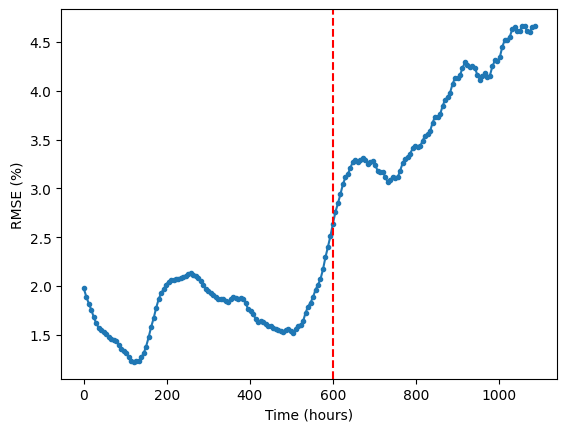

In [129]:
time_vector = np.arange(0, len(rmse))*delta_time
plt.plot(time_vector, rmse*100, '.-')
# add a vertical line at the time when the prediction starts
plt.axvline(T_train*delta_time, linestyle = '--', color = 'r')
plt.xlabel('Time (hours)')
plt.ylabel('RMSE (%)')